https://huggingface.co/spaces/wendys-llc/pdfplumber-demo

https://github.com/jsvine/nicar-2023-pdfplumber-workshop/tree/main

https://github.com/jsvine/lede-2023/tree/main/pdf-parsing

https://github.com/jsvine/pdfplumber/?tab=readme-ov-file#extracting-text

https://github.com/hananedupouy/LLMs-in-Finance/blob/main/Multimodal_llms/financial_analysis/multimodal_claude3_5_sonnet_gpt4o_claude3_opus_charts_analysis.ipynb

https://blog.knowledgator.com/extract-custom-table-from-pdf-with-llms-2ad678c26200

In [71]:
import nest_asyncio
nest_asyncio.apply()

import os
import pdfplumber

In [72]:
# pdfplumber.open("file.pdf", password = "test")
esi = pdfplumber.open('../data/esi/esi2023.pdf')

In [73]:
# open method above returns an instance of the pdfplumber.PDF class
type(esi)

pdfplumber.pdf.PDF

In [74]:
len(esi.pages)

414

In [75]:
# create instance of pdfplumber.Page class
no = 51
page = esi.pages[no]
print(type(page))

<class 'pdfplumber.page.Page'>


In [76]:
print(dir(page))

['__annotations__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_get_textmap', 'annots', 'bbox', 'cached_properties', 'chars', 'close', 'crop', 'cropbox', 'curve_edges', 'curves', 'debug_tablefinder', 'dedupe_chars', 'edges', 'extract_table', 'extract_tables', 'extract_text', 'extract_text_lines', 'extract_text_simple', 'extract_words', 'filter', 'find_table', 'find_tables', 'flush_cache', 'get_textmap', 'height', 'horizontal_edges', 'hyperlinks', 'images', 'initial_doctop', 'is_original', 'iter_layout_objects', 'layout', 'lines', 'mediabox', 'objects', 'outside_bbox', 'page_number', 'page_obj', 'pages', 'parse_objects', 'pdf', 'point2coord', 'process_object', 'rect_edges', 

In [77]:
print(page.extract_text())

10 Economic Survey 2022-23
Broad-based growth driven by Demand and Investment
figure I.10a: yoy growth of Real figure I.10b: Share of Real
Gva components GDp components
8
3
-2
-7
-12
tnec
reP
)ER
dr3(
91YF
)ER
dn2(
02YF
)ER
ts1(
12YF
)EP(
22YF
)EA
ts1(
32YF
Agriculture and allied activities
Industry
Services
80
60
40
20
0
PFCE GFCF Exports of Imports of
goods and goods and
services services
PDG
fo
tnec
reP
FY19 (3rd RE) FY20 (2nd RE) FY21 (1st RE)
FY22 (PE) FY23 (1st AE)
Source: NSO, MoSPI
Note: AE stands for Advanced Estimates, PE stands for Provisional Estimates, RE stands for Revised Estimates
figure I.11: cpI Inflation eased back figure I.12: Indian Rupee performed
to RBI’s target range well compared to other emes
10
8
6
4
2
0
)YoY(
tnec
reP
12-beF 12-rpA 12-nuJ 12-guA 12-tcO 12-ceD 22-beF 22-rpA 22-nuJ 22-guA 22-tcO 22-ceD
CPI CPI-Food Depreciation (+)/Appreciation(-)
against USD between Apr-Dec 2022
South Africa 16.4
Brazil 11.5
Australia 10.0
Indonesia 8.8
India 8.8
China 8.8
UK

In [78]:
print(page.extract_text(layout=True))

                                                                                  
                                                                                  
                                                                                  
          10   Economic Survey 2022-23                                            
                                                                                  
                                                                                  
                     Broad-based growth driven by Demand and Investment           
                                                                                  
              figure I.10a: yoy growth of Real  figure I.10b: Share of Real       
                    Gva components                 GDp components                 
                                                                                  
                                                                                  
    

In [79]:
# number of rectangles
type(page.rects), len(page.rects)

(list, 84)

In [80]:
# number of curved objects
len(page.curves)

86

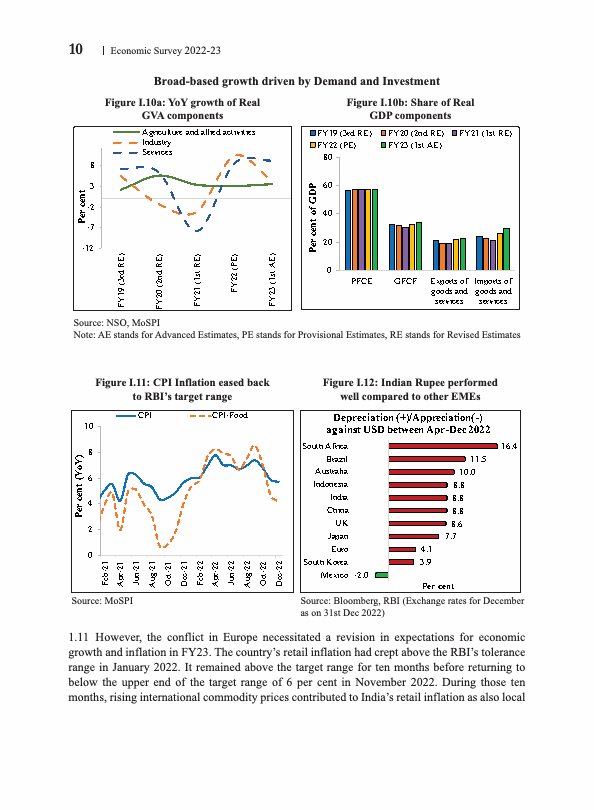

In [81]:
im = page.to_image()
im

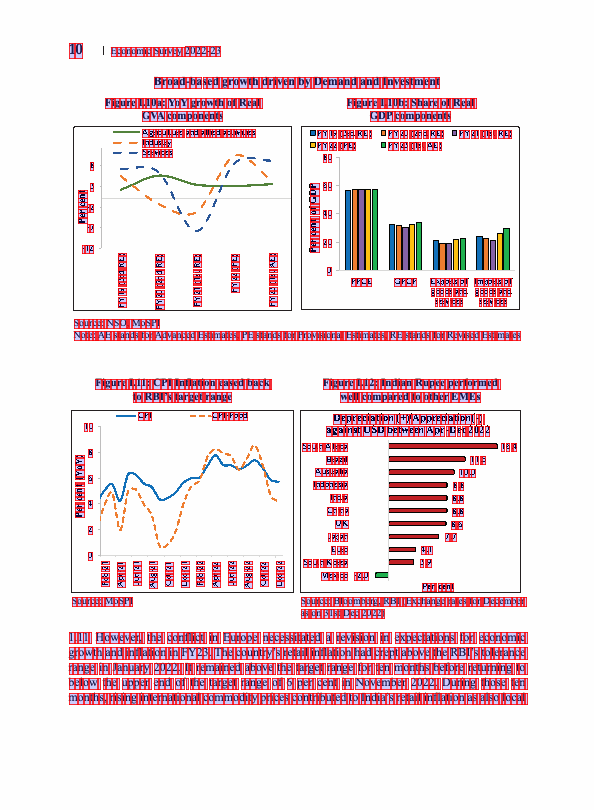

In [82]:
im.reset().draw_rects(page.chars)

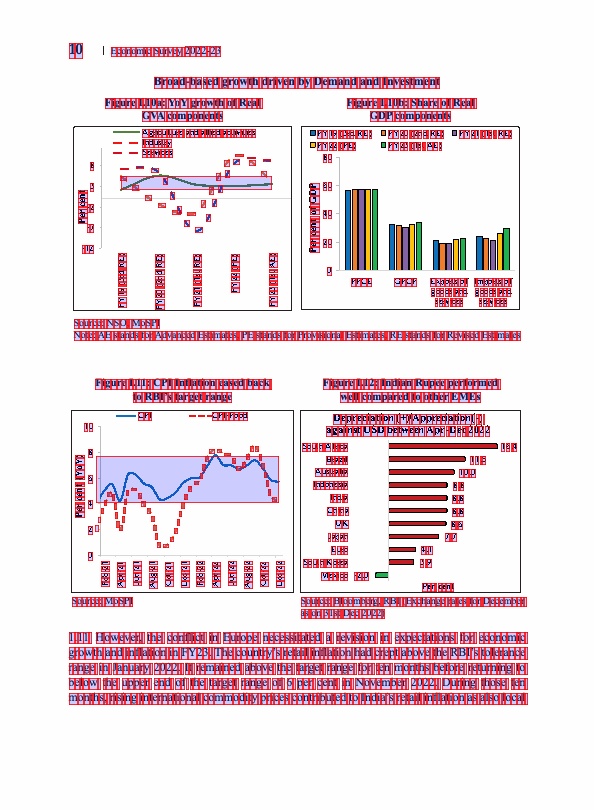

In [83]:
im.draw_rects(page.curves)

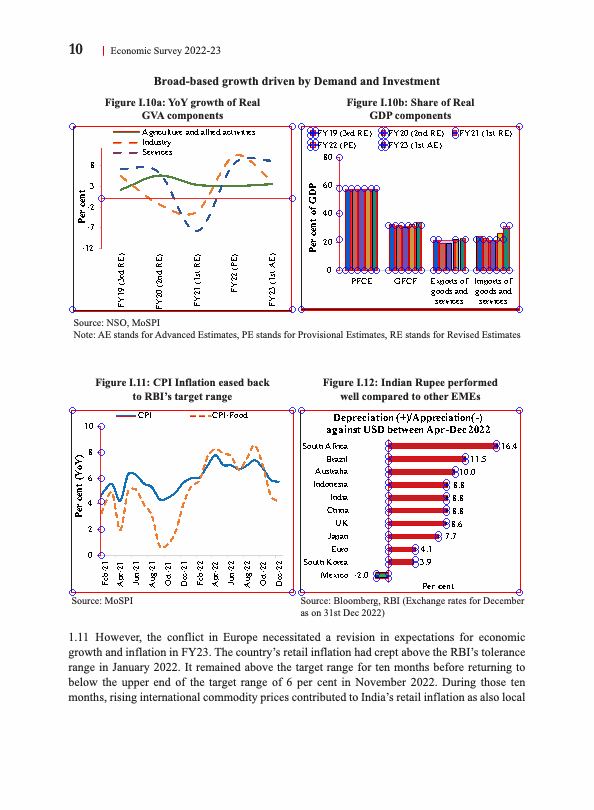

In [84]:
im.reset().debug_tablefinder()

In [85]:
page.extract_tables()

[[['', '', '', '', '']],
 [['', '', '', '', '']],
 [[None, None, None, None, ''], ['', '', '', '', None]],
 [['', '', '']]]

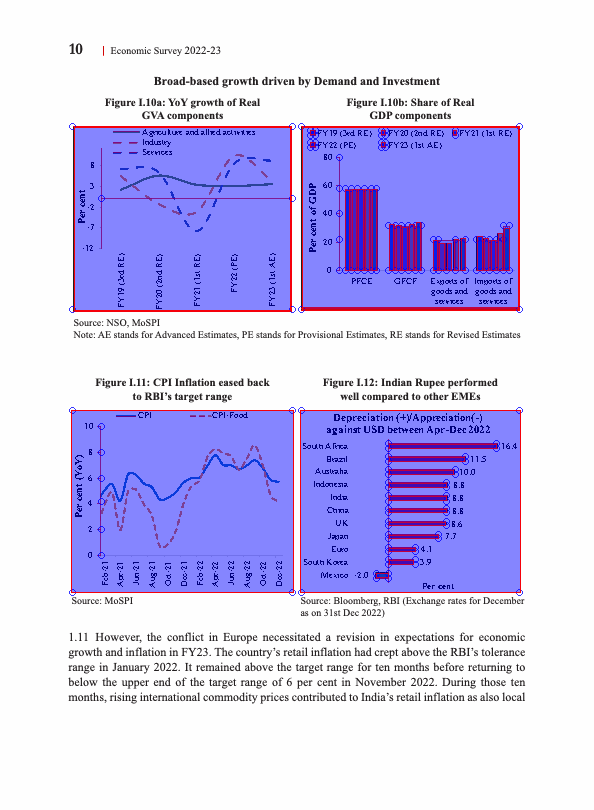

In [86]:
im.draw_rects(page.rects)

In [87]:
top_rect = page.rects[5]
top_rect_bbox = pdfplumber.utils.obj_to_bbox(top_rect)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=150)

In [88]:
print(top_rect)

{'x0': 344.755, 'y0': 538.949, 'x1': 349.755, 'y1': 618.949, 'width': 5.0, 'height': 80.0, 'pts': [(344.755, 270.0590000000001), (349.755, 270.0590000000001), (349.755, 190.05900000000008), (344.755, 190.05900000000008)], 'linewidth': 0.5, 'stroke': False, 'fill': True, 'evenodd': False, 'stroking_color': (0, 0, 0, 1), 'non_stroking_color': (0.868, 0.537, 0, 0), 'mcid': None, 'tag': 'PlacedPDF', 'object_type': 'rect', 'page_number': 52, 'stroking_pattern': None, 'non_stroking_pattern': None, 'path': [('m', (344.755, 270.0590000000001)), ('l', (349.755, 270.0590000000001)), ('l', (349.755, 190.05900000000008)), ('l', (344.755, 190.05900000000008)), ('h',)], 'dash': None, 'top': 190.05900000000008, 'bottom': 270.0590000000001, 'doctop': 41449.46700000005}


In [89]:
top_rect["x0"], top_rect["top"], top_rect["x1"], top_rect["bottom"]

(344.755, 190.05900000000008, 349.755, 270.0590000000001)

In [90]:
page.rects[5]['x1'], page.rects[6]['x0'], page.rects[1]['x1'], page.rects[2]['x0']

(349.755, 388.755, 290.753, 73.753)

In [91]:
page.rects[1]['x1']

290.753

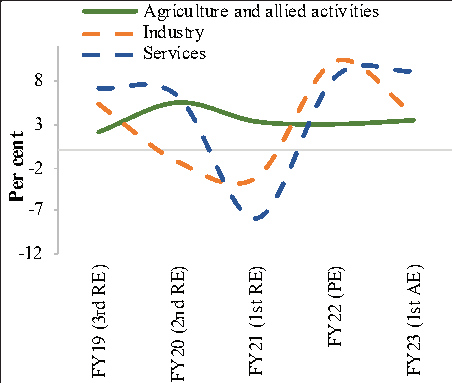

In [92]:
top_rect = page.rects[1]
top_rect_bbox = pdfplumber.utils.obj_to_bbox(top_rect)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=150)

In [93]:
def group_adjacent_rectangles(rectangles, distance_threshold):
    """
    Group a list of rectangles into adjacent sets if the coordinates overlap or the distance between the rectangles
    is less than a specified value.
    
    Parameters:
    rectangles (list of tuples): A list of tuples where each tuple contains four integers (x1, y1, x2, y2) representing the coordinates of the bottom-left and top-right corners of a rectangle.
    distance_threshold (int): The maximum distance between rectangles to consider them as adjacent.
    
    Returns:
    list of lists of tuples: A list where each element is a list of tuples representing a group of adjacent rectangles.
    """
    def rectangles_overlap_or_close(rect1, rect2, threshold):
        # Check if rectangles overlap
        if not (rect1[2] < rect2[0] or rect1[0] > rect2[2] or rect1[3] < rect2[1] or rect1[1] > rect2[3]):
            return True
        # Check if rectangles are within the distance threshold
        if (abs(rect1[2] - rect2[0]) <= threshold or abs(rect1[0] - rect2[2]) <= threshold) and \
           (rect1[1] <= rect2[3] and rect1[3] >= rect2[1]):
            return True
        if (abs(rect1[3] - rect2[1]) <= threshold or abs(rect1[1] - rect2[3]) <= threshold) and \
           (rect1[0] <= rect2[2] and rect1[2] >= rect2[0]):
            return True
        return False

    def find_adjacent_group(rect, remaining_rects, threshold):
        group = [rect]
        to_check = [rect]
        while to_check:
            current = to_check.pop()
            for other in remaining_rects[:]:
                if rectangles_overlap_or_close(current, other, threshold):
                    group.append(other)
                    to_check.append(other)
                    remaining_rects.remove(other)
        return group

    remaining_rects = rectangles[:]
    groups = []
    while remaining_rects:
        rect = remaining_rects.pop(0)
        group = find_adjacent_group(rect, remaining_rects, distance_threshold)
        groups.append(group)
    
    return groups

# Example usage:
# rectangles = [(1, 2, 3, 4), (2, 3, 5, 6), (10, 10, 12, 12), (11, 11, 13, 13),(21,22,23,24),(22,23,24,25),(23,24,25,26)]
# rectangles = [
#     ((1, 2, 4, 5)),
#     ((2, 3, 5, 7)),
#     ((0, 1, 6, 8)),
#     ((3, 0, 7, 6)),
#     ((10, 10, 12, 12)),
#     ((-1, -2, 2, 3)),
#     ((0, 0, 3, 4)),
#     ((-2, -3, 1, 1))
# ]
rectangles = [
    (1, 2, 4, 5),
    (2, 3, 5, 7),
    (0, 1, 6, 8),
    (3, 0, 7, 6),
    (10, 10, 12, 12),
    (-1, -2, 2, 3),
    (0, 0, 3, 4),
    (-2, -3, 1, 1),
]
distance_threshold = 1
adjacent_groups = group_adjacent_rectangles(rectangles, distance_threshold)
for adj in adjacent_groups:
    print(adj)  
# Output: [[(1, 2, 3, 4), (2, 3, 5, 6)], [(10, 10, 12, 12), (11, 11, 13, 13)]]


[(1, 2, 4, 5), (2, 3, 5, 7), (0, 1, 6, 8), (3, 0, 7, 6), (-1, -2, 2, 3), (0, 0, 3, 4), (-2, -3, 1, 1)]
[(10, 10, 12, 12)]


In [94]:
# list of all rectangle objects on the page
all_rects = page.rects
type(all_rects), len(all_rects), type(all_rects[0])

(list, 84, dict)

In [95]:
print(all_rects[0])# , all_rects[1]

{'x0': 73.752, 'y0': 498.449, 'x1': 290.753, 'y1': 682.4490000000001, 'width': 217.00099999999998, 'height': 184.00000000000006, 'pts': [(73.752, 310.559), (290.753, 310.559), (290.753, 126.55899999999997), (73.752, 126.55899999999997)], 'linewidth': 0, 'stroke': False, 'fill': True, 'evenodd': False, 'stroking_color': None, 'non_stroking_color': (0, 0, 0, 0), 'mcid': None, 'tag': 'PlacedPDF', 'object_type': 'rect', 'page_number': 52, 'stroking_pattern': None, 'non_stroking_pattern': None, 'path': [('m', (73.752, 310.559)), ('l', (290.753, 310.559)), ('l', (290.753, 126.55899999999997)), ('l', (73.752, 126.55899999999997)), ('h',)], 'dash': None, 'top': 126.55899999999997, 'bottom': 310.559, 'doctop': 41385.96700000005}


In [96]:

# for i in range(len(all_rects)):
#     rect_tuple.append((all_rects[i]['x0'], all_rects[i]['y0'], all_rects[i]['x1'], all_rects[i]['y1']))

rect_tuple = []    
# Loop over the dictionary and create a tuple of rectangle box co-ordinate values from the dictionary
for i in range(len(all_rects)):
    rect_tuple.append((all_rects[i]['x0'], all_rects[i]['y0'], all_rects[i]['x1'], all_rects[i]['y1']))


In [97]:
# verify length equal 
len(rect_tuple) == len(all_rects) == 34

False

In [98]:
# combine overlapping rectangles into a tuple of rectangles
distance_threshold = 5
adjacent_groups = group_adjacent_rectangles(rect_tuple, distance_threshold)
print(len(adjacent_groups))
for adj in adjacent_groups:
    print(len(adj))


4
3
53
3
25


In [99]:
# find outermost rectangle co-ordinates for each tuple of rectangles as identified above
outer_rects = []
for group in adjacent_groups:
    x0 = min(group, key=lambda x: x[0])[0]
    y0 = min(group, key=lambda x: x[1])[1]
    x1 = max(group, key=lambda x: x[2])[2]
    y1 = max(group, key=lambda x: x[3])[3]
    outer_rects.append([x0, y0, x1, y1])

In [100]:
print(type(outer_rects), len(outer_rects), type(outer_rects[0]))
for rect in outer_rects:
    print(rect)

<class 'list'> 4 <class 'list'>
[73.752, 498.449, 290.753, 682.4490000000001]
[301.255, 499.487, 518.255, 682.4490000000001]
[71.253, 217.458, 293.253, 399.459]
[299.755, 217.458, 519.755, 399.459]


In [101]:
print(page.height, page.width, outer_rects[0])
page.height-outer_rects[0][1]

809.008 593.008 [73.752, 498.449, 290.753, 682.4490000000001]


310.559

(73.752, 498.449, 290.753, 682.4490000000001)


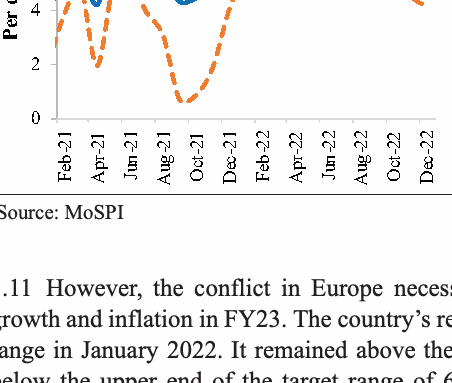

In [102]:
top_rect_bbox = (outer_rects[0][0], outer_rects[0][1], outer_rects[0][2], outer_rects[0][3])
print(top_rect_bbox)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=150)

In [103]:
type(bbox_rects), len(bbox_rects), type(bbox_rects[0]), bbox_rects[0]

(list, 4, list, [73.751, 116.1880000000001, 291.754, 298.18800000000005])

(73.751, 116.1880000000001, 291.754, 298.18800000000005)


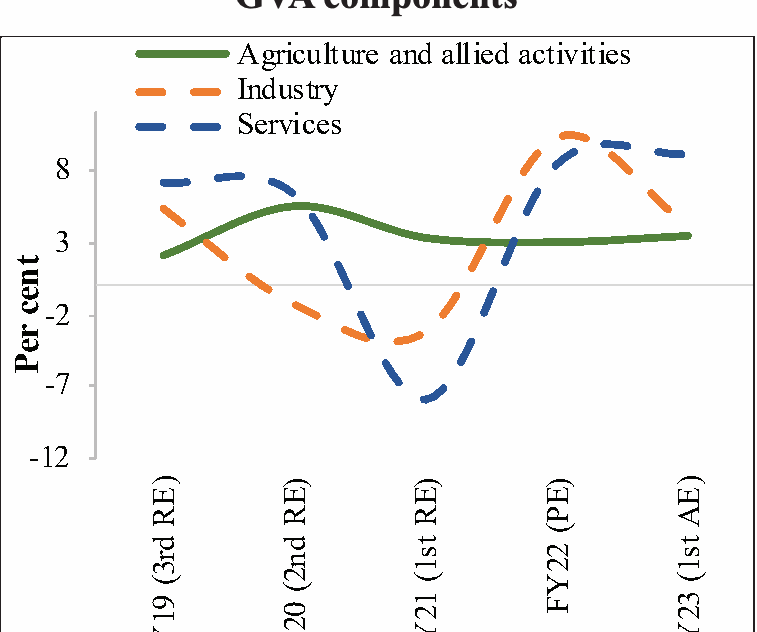

In [104]:
top_rect_bbox = (bbox_rects[0][0], bbox_rects[0][1], bbox_rects[0][2], bbox_rects[0][3])
print(top_rect_bbox)
top_rect_cropped = page.crop(top_rect_bbox)
top_rect_cropped.to_image(resolution=250)

In [105]:
# convert each element of outer_rects to format for creating bounding box
bbox_rects = []
for rect in outer_rects:
    x0 = rect[0]
    top = page.height-rect[3]
    x1 = rect[2]
    bottom = page.height-rect[1]
    bbox_rects.append([x0, top, x1, bottom])
    

In [113]:
for rect in bbox_rects:
    print(rect)
    bbox = (rect[0], rect[1], rect[2], rect[3])
    # print(bbox)
    bbox_cropped = page.crop(bbox)
    ia = bbox_cropped.to_image(resolution=250)
    ia.show()
    

[73.752, 126.55899999999997, 290.753, 310.559]


[301.255, 126.55899999999997, 518.255, 309.521]
[71.253, 409.54900000000004, 293.253, 591.5500000000001]
[299.755, 409.54900000000004, 519.755, 591.5500000000001]
